<a href="https://www.kaggle.com/code/vcsaisanthosh/time-series-store-sales-data?scriptVersionId=213777961" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sales-forecasting/train.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import probplot
from datetime import datetime
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

warnings.filterwarnings("ignore")
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
df = pd.read_csv("/kaggle/input/sales-forecasting/train.csv")

In [4]:
print("Initial Shape:", df.shape)
print("\nData Types and Null Counts:")
print(df.info())

Initial Shape: (9800, 18)

Data Types and Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 1

In [5]:
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64


In [6]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product

In [7]:
drop_cols = ["Row ID", "Country", "Postal Code"]
for c in drop_cols:
    if c in df.columns:
        df.drop(c, axis=1, inplace=True)

In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y', errors='coerce')

In [9]:
print("\nNumber of NaN in 'Order Date':", df['Order Date'].isnull().sum())
print("Number of NaN in 'Ship Date':", df['Ship Date'].isnull().sum())


Number of NaN in 'Order Date': 0
Number of NaN in 'Ship Date': 0


In [10]:
df.dropna(subset=['Order Date', 'Sales'], inplace=True)

In [11]:
if (df['Sales'] < 0).any():
    print("Warning: Negative sales values found.")

In [12]:
dup_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", dup_count)
if dup_count > 0:
    df.drop_duplicates(inplace=True)


Number of duplicate rows: 1


In [13]:
print("\nDate Range of Dataset:")
print("Start Date:", df['Order Date'].min())
print("End Date:", df['Order Date'].max())


Date Range of Dataset:
Start Date: 2015-01-03 00:00:00
End Date: 2018-12-30 00:00:00


In [14]:
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Sales'] < lower_bound) | (df['Sales'] > upper_bound)]
print("\nNumber of outliers detected in Sales:", outliers.shape[0])


Number of outliers detected in Sales: 1145


In [15]:
df.sort_values('Order Date', inplace=True)
df.set_index('Order Date', inplace=True)

In [16]:
monthly_sales = df['Sales'].resample('M').sum()
print("\nMonthly Aggregated Sales (first 5):")
print(monthly_sales.head())

print("Monthly Series Shape:", monthly_sales.shape)


Monthly Aggregated Sales (first 5):
Order Date
2015-01-31    14205.707
2015-02-28     4519.892
2015-03-31    55205.797
2015-04-30    27625.483
2015-05-31    23644.303
Freq: ME, Name: Sales, dtype: float64
Monthly Series Shape: (48,)


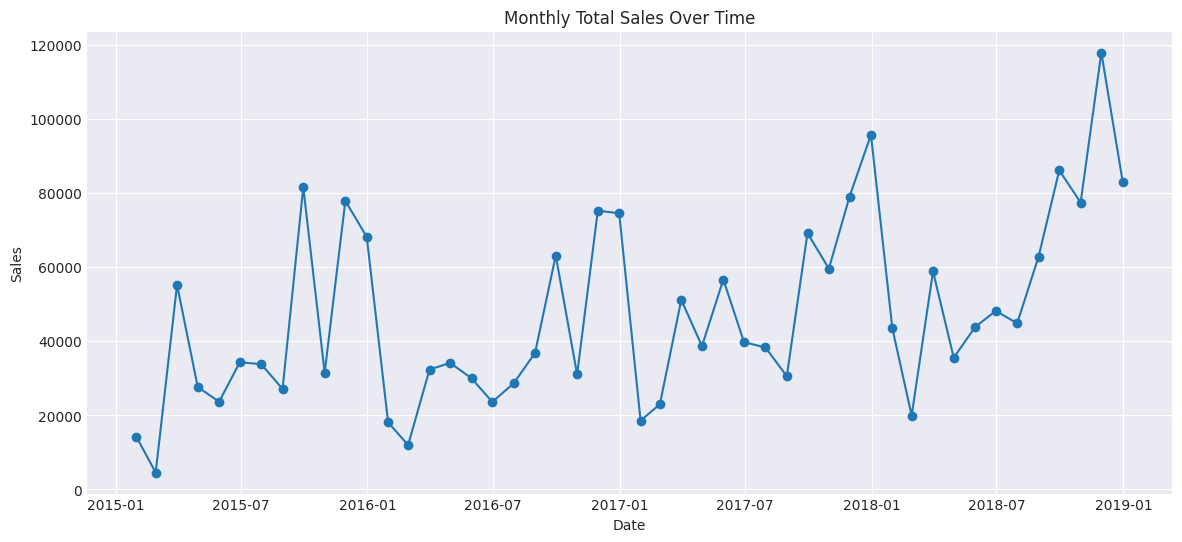

In [17]:
plt.figure(figsize=(14,6))
plt.plot(monthly_sales, marker='o', linewidth=1.5)
plt.title("Monthly Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [18]:
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    print("ADF Test Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value}")
    if result[1] < 0.05:
        print("Stationary according to ADF test (p<0.05).")
    else:
        print("Non-stationary according to ADF test.")

In [19]:
def kpss_test(series, regression='c'):
    statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression=regression)
    print("KPSS Test Statistic:", statistic)
    print("p-value:", p_value)
    for key, value in critical_values.items():
        print(f"Critical Value {key}: {value}")
    if p_value < 0.05:
        print("Non-stationary according to KPSS test (p<0.05).")
    else:
        print("Likely stationary according to KPSS test.")

In [20]:
print("\n===== Stationarity Tests on Original Monthly Sales =====")
adf_test(monthly_sales)
kpss_test(monthly_sales, regression='c')


===== Stationarity Tests on Original Monthly Sales =====
ADF Test Statistic: -4.416028120656409
p-value: 0.0002780338735027915
Critical Value 1%: -3.5778480370438146
Critical Value 5%: -2.925338105429433
Critical Value 10%: -2.6007735310095064
Stationary according to ADF test (p<0.05).
KPSS Test Statistic: 0.6296370436191563
p-value: 0.019942086943713064
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
Non-stationary according to KPSS test (p<0.05).


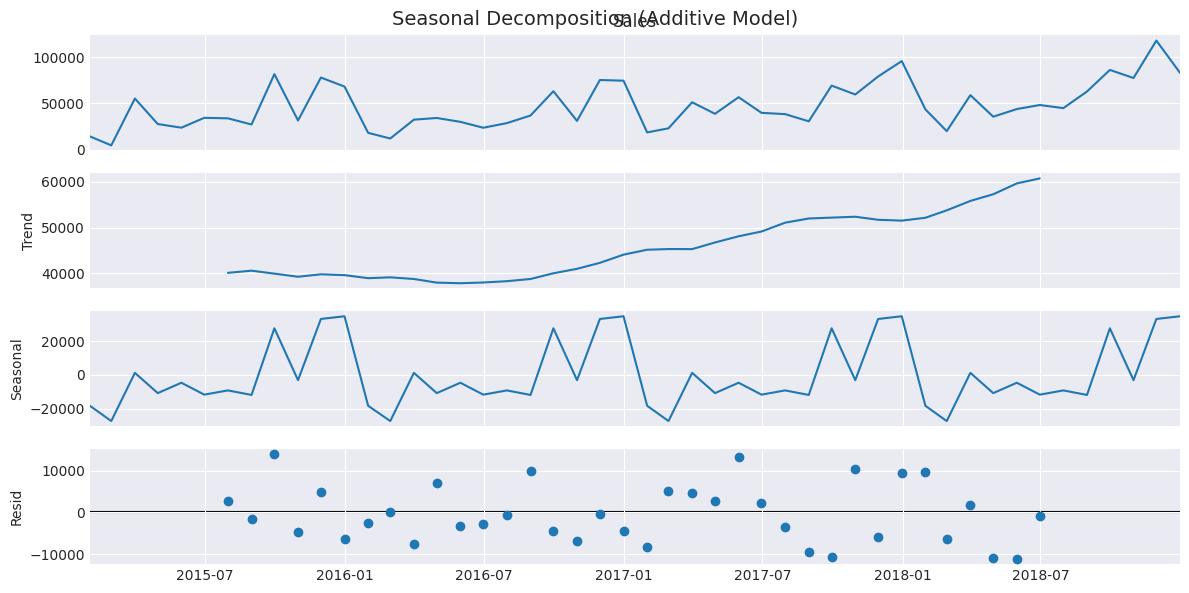

In [21]:
decomp_result = seasonal_decompose(monthly_sales, model='additive', period=12)
decomp_result.plot()
plt.suptitle("Seasonal Decomposition (Additive Model)", fontsize=14)
plt.show()

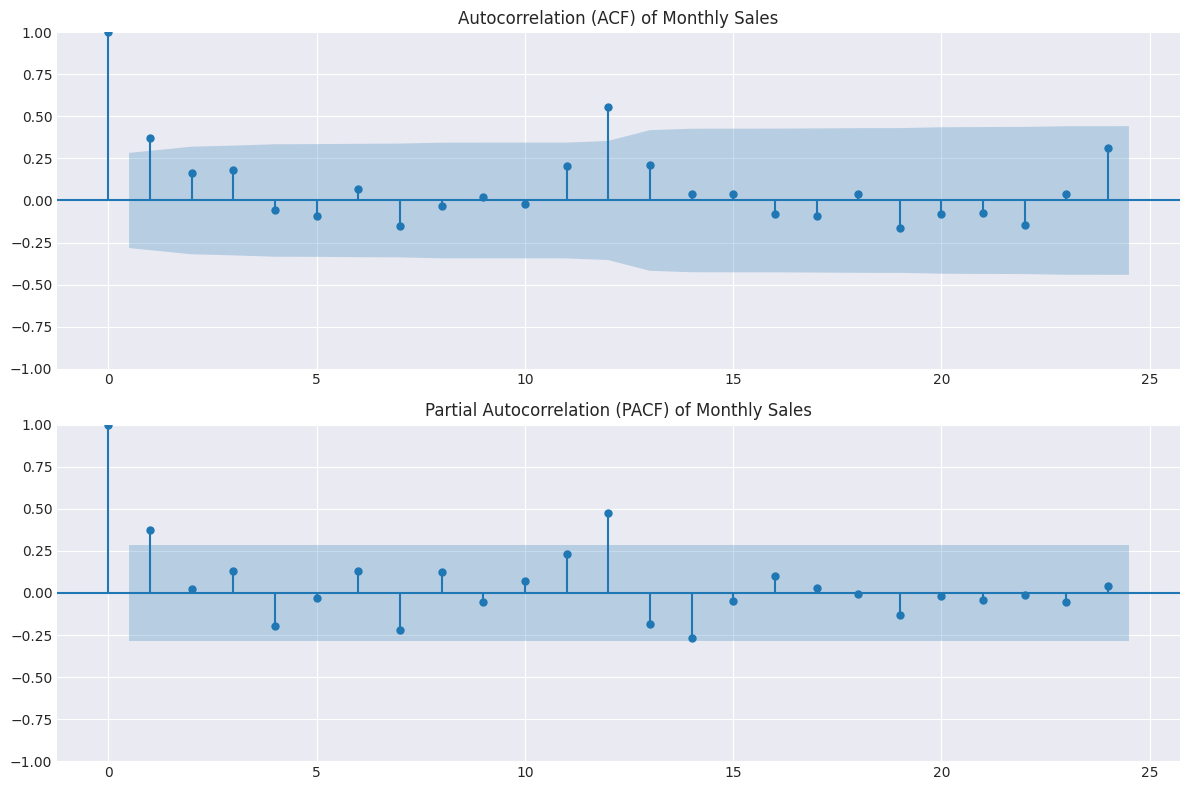

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(monthly_sales.dropna(), ax=ax[0], lags=24)
ax[0].set_title("Autocorrelation (ACF) of Monthly Sales")
plot_pacf(monthly_sales.dropna(), ax=ax[1], lags=24, method='ywm')
ax[1].set_title("Partial Autocorrelation (PACF) of Monthly Sales")
plt.tight_layout()
plt.show()

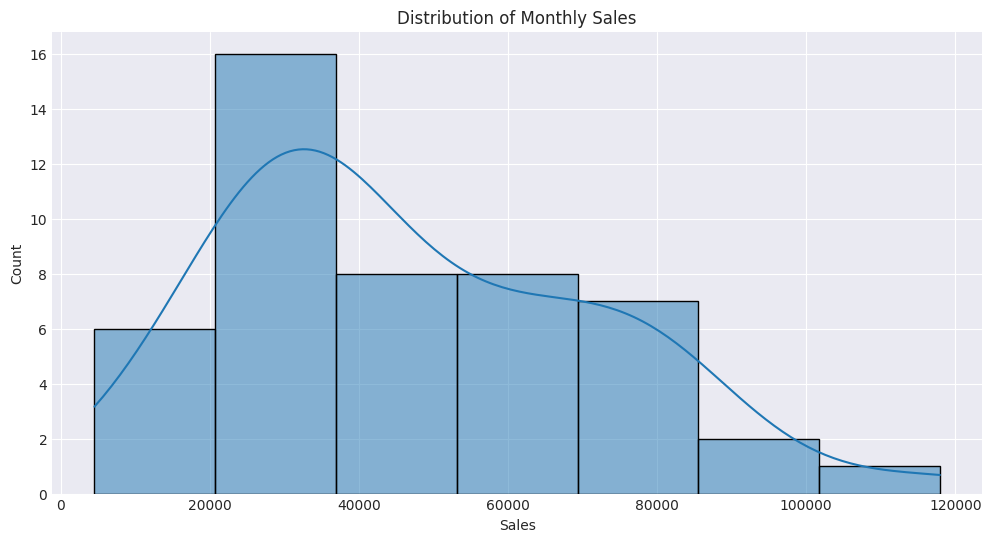

In [23]:
sns.histplot(monthly_sales, kde=True)
plt.title("Distribution of Monthly Sales")
plt.show()

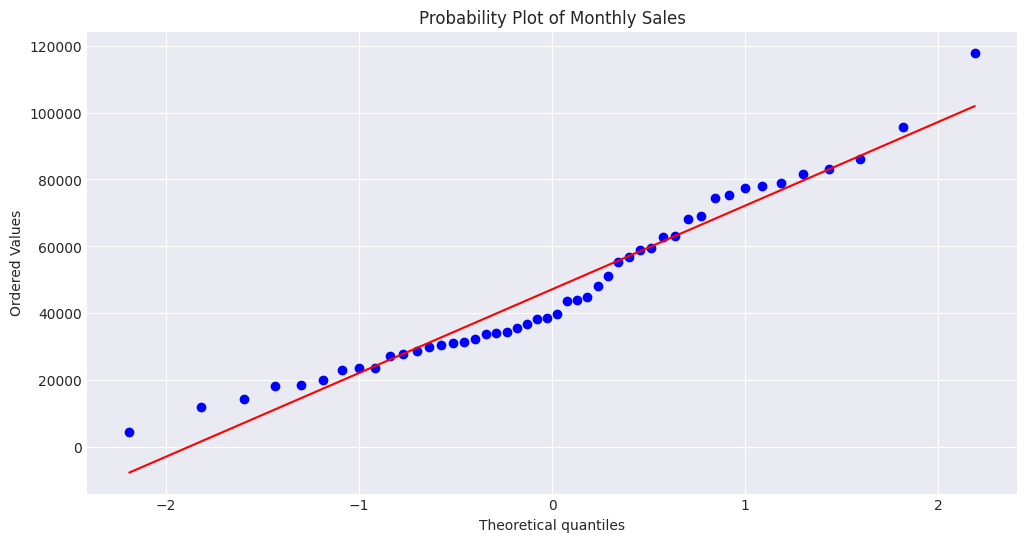

In [24]:
fig = plt.figure()
probplot(monthly_sales.dropna(), plot=plt)
plt.title("Probability Plot of Monthly Sales")
plt.show()

In [25]:
if (monthly_sales <= 0).any():
    shift = abs(monthly_sales.min()) + 1
    log_sales = np.log(monthly_sales + shift)
else:
    log_sales = np.log(monthly_sales)

In [26]:
print("\nCheck stationarity after log transform:")
adf_test(log_sales)
kpss_test(log_sales, regression='c')


Check stationarity after log transform:
ADF Test Statistic: -4.857811505492765
p-value: 4.2104675429638714e-05
Critical Value 1%: -3.5778480370438146
Critical Value 5%: -2.925338105429433
Critical Value 10%: -2.6007735310095064
Stationary according to ADF test (p<0.05).
KPSS Test Statistic: 0.8163388632027866
p-value: 0.01
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
Non-stationary according to KPSS test (p<0.05).


In [27]:
log_diff = log_sales.diff().dropna()

print("\n===== Stationarity Tests after First Differencing the Log Series =====")
adf_test(log_diff)
kpss_test(log_diff, regression='c')


===== Stationarity Tests after First Differencing the Log Series =====
ADF Test Statistic: -9.02138391890655
p-value: 5.762798264474741e-15
Critical Value 1%: -3.626651907578875
Critical Value 5%: -2.9459512825788754
Critical Value 10%: -2.6116707716049383
Stationary according to ADF test (p<0.05).
KPSS Test Statistic: 0.32798384255113916
p-value: 0.1
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
Likely stationary according to KPSS test.


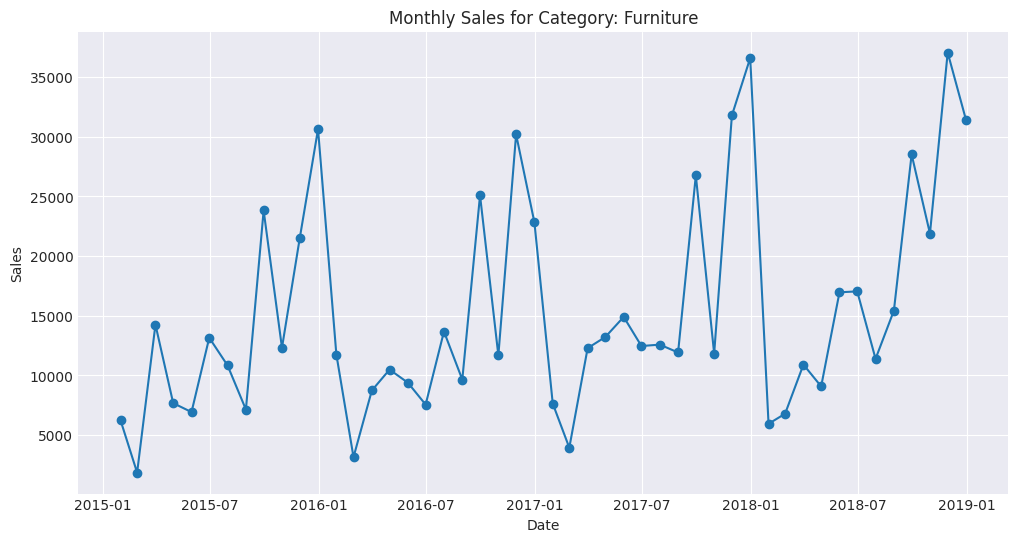

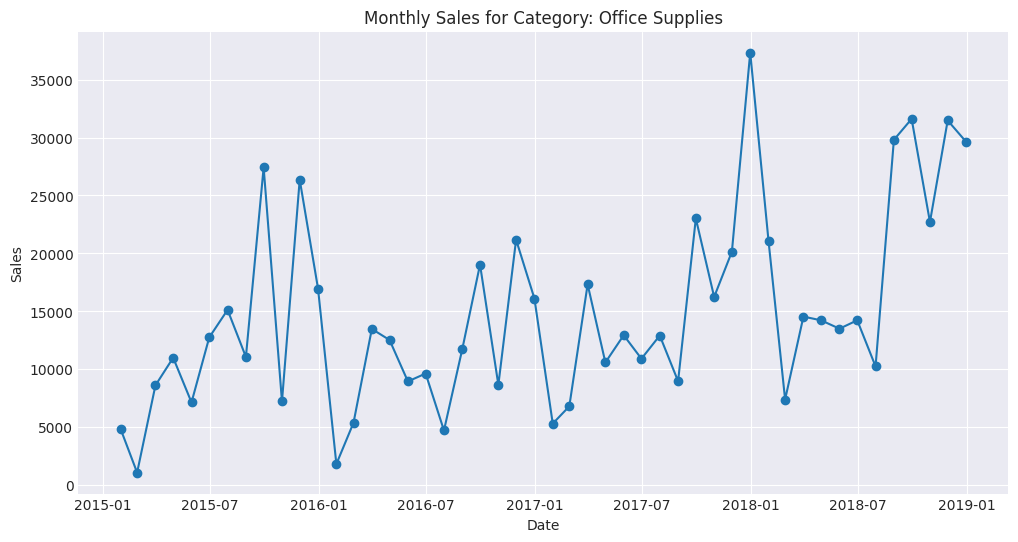

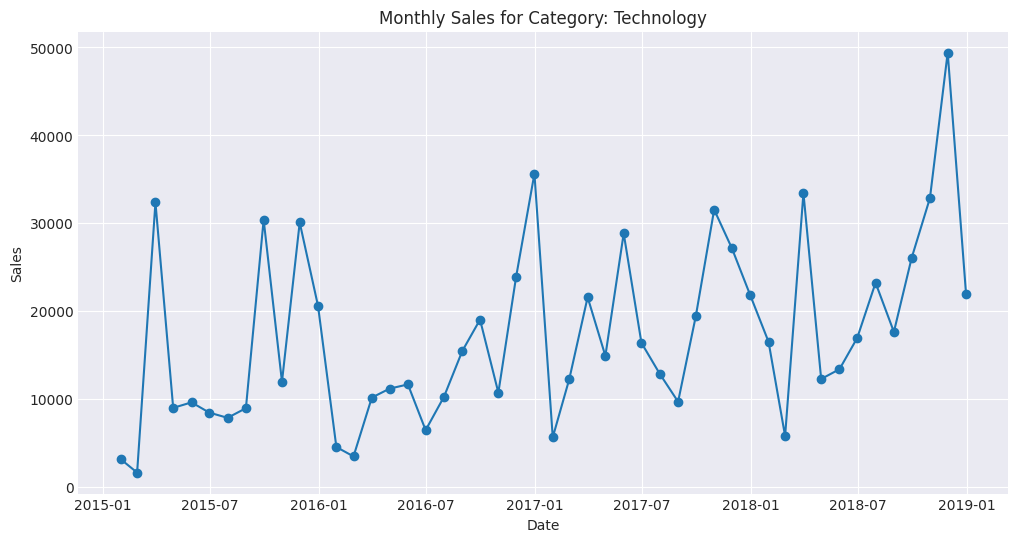

In [28]:
if 'Category' in df.columns:
    category_sales = df.groupby('Category')['Sales'].resample('M').sum()
    unique_cats = category_sales.index.get_level_values(0).unique()
    for cat in unique_cats:
        plt.figure()
        plt.plot(category_sales[cat], marker='o')
        plt.title(f"Monthly Sales for Category: {cat}")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.show()

In [29]:
monthly_df = monthly_sales.to_frame(name='Sales')
monthly_df['Year'] = monthly_df.index.year
monthly_df['Month'] = monthly_df.index.month
monthly_df['Quarter'] = monthly_df.index.quarter

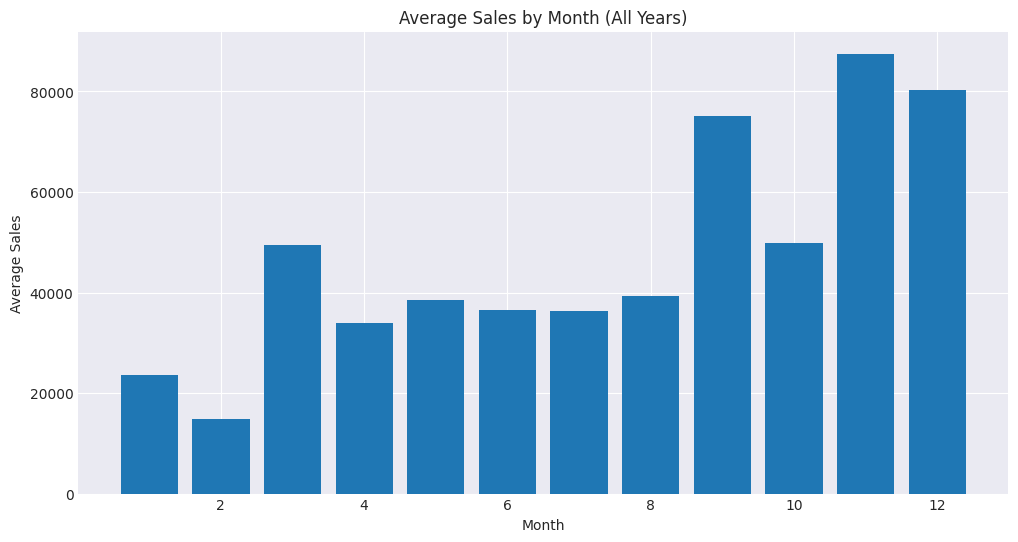

In [30]:
monthly_pattern = monthly_df.groupby('Month')['Sales'].mean()
plt.bar(monthly_pattern.index, monthly_pattern.values)
plt.title("Average Sales by Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

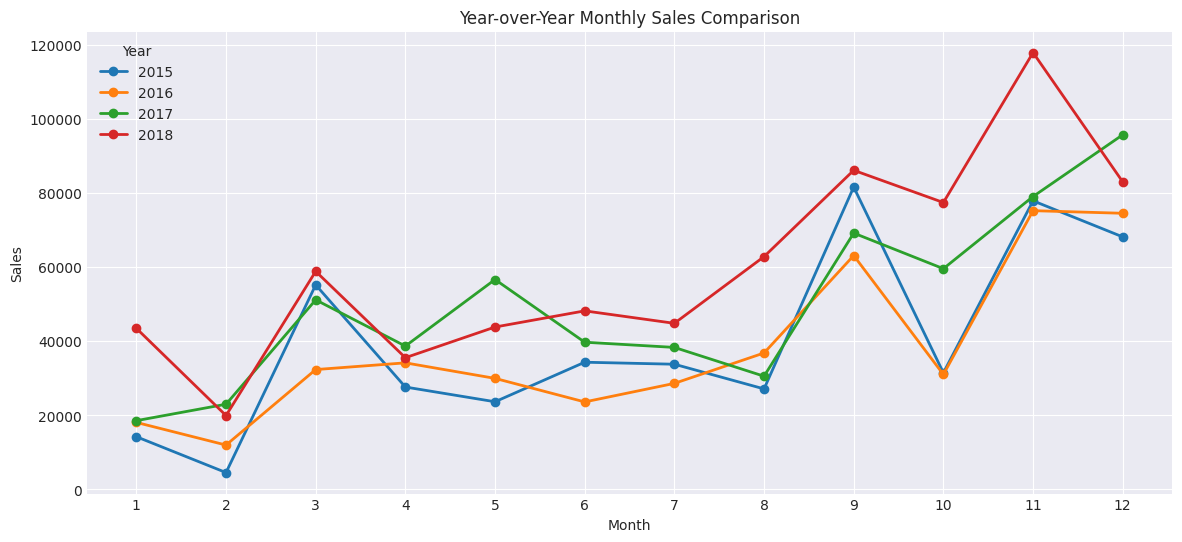

In [31]:
monthly_df = monthly_sales.to_frame('Sales')
monthly_df['Year'] = monthly_df.index.year
monthly_df['Month'] = monthly_df.index.month

yoy = monthly_df.pivot_table(values='Sales', index='Month', columns='Year')

plt.figure(figsize=(14,6))
for year in yoy.columns:
    plt.plot(yoy.index, yoy[year], marker='o', linewidth=2, label=str(year))
plt.title("Year-over-Year Monthly Sales Comparison")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(range(1,13))
plt.legend(title='Year')
plt.show()

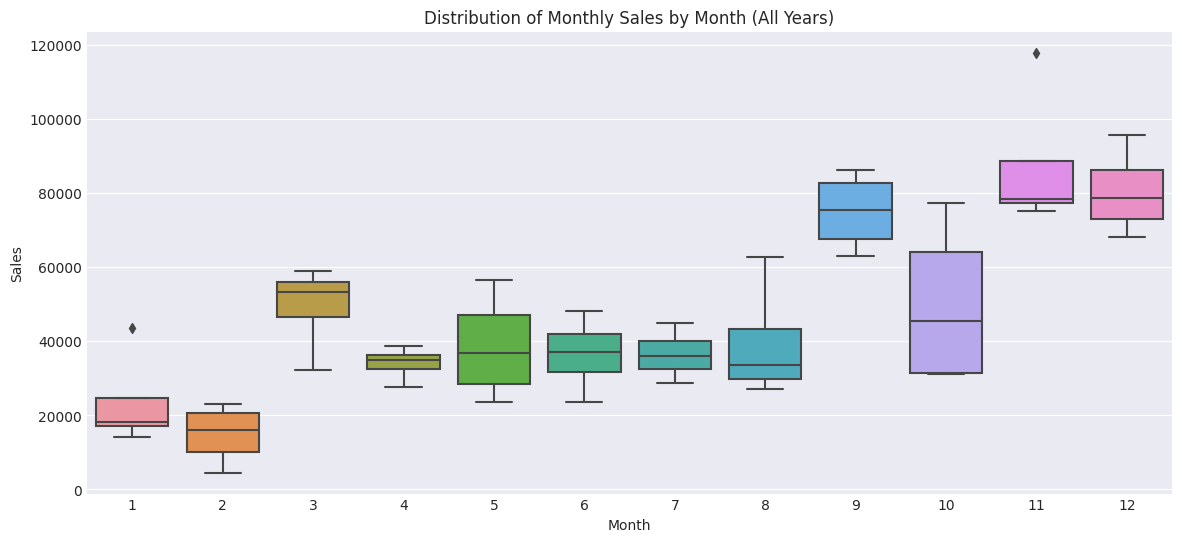

In [32]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Month', y='Sales', data=monthly_df)
plt.title("Distribution of Monthly Sales by Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

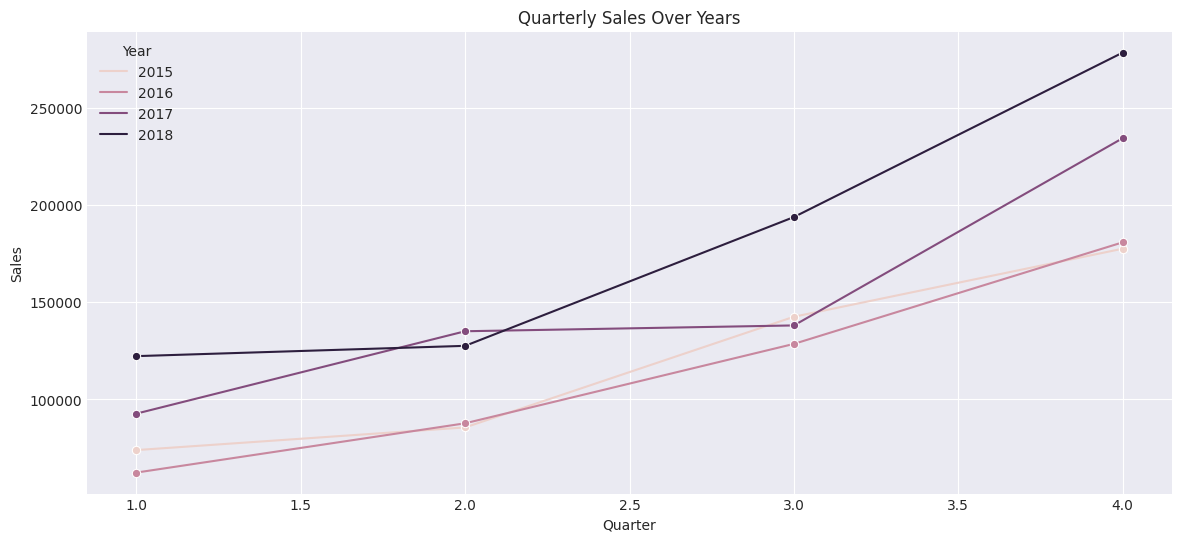

In [33]:
monthly_df['Quarter'] = monthly_df.index.quarter
quarterly_df = monthly_df.groupby(['Year', 'Quarter'])['Sales'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(x='Quarter', y='Sales', hue='Year', data=quarterly_df, marker='o')
plt.title("Quarterly Sales Over Years")
plt.xlabel("Quarter")
plt.ylabel("Sales")
plt.show()

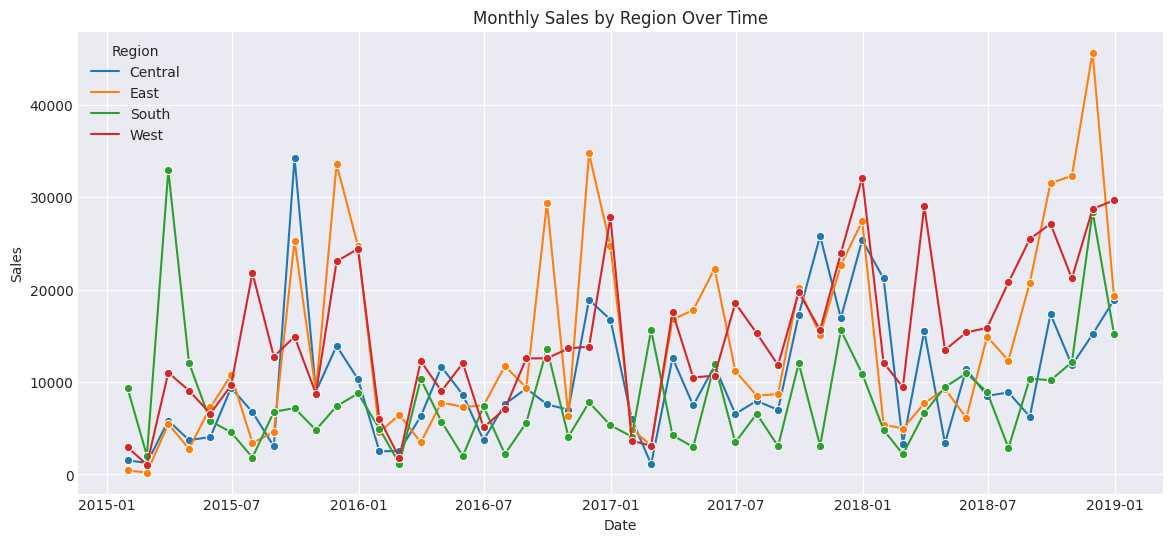

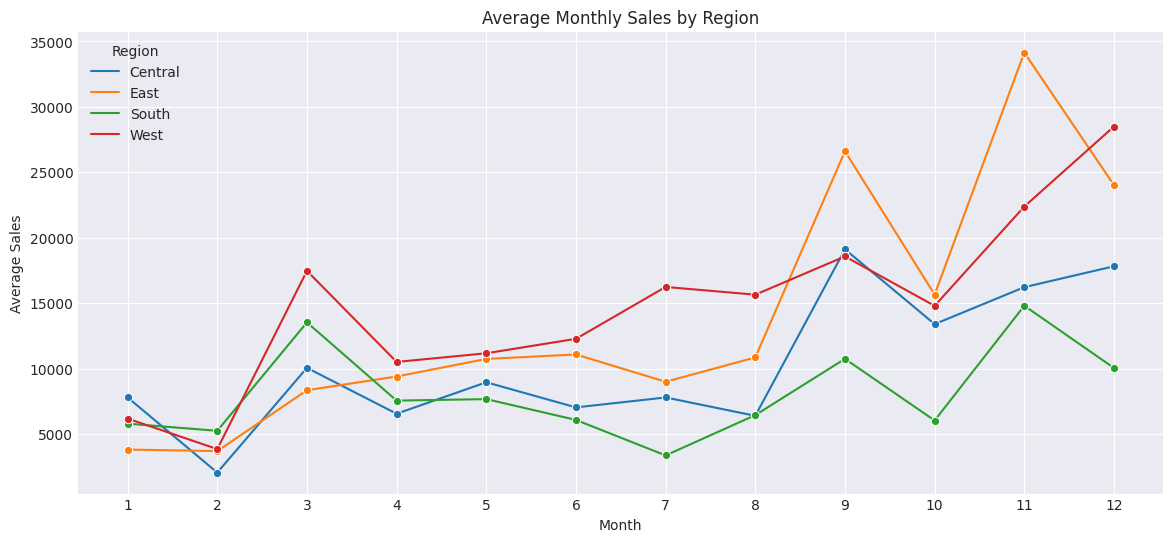

In [34]:
if 'Region' in df.columns:
    region_monthly = df.groupby(['Region']).resample('M')['Sales'].sum().reset_index()
    plt.figure(figsize=(14,6))
    sns.lineplot(data=region_monthly, x='Order Date', y='Sales', hue='Region', marker='o')
    plt.title("Monthly Sales by Region Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.show()
    
    region_monthly['Month'] = region_monthly['Order Date'].dt.month
    region_avg = region_monthly.groupby(['Region', 'Month'])['Sales'].mean().reset_index()

    plt.figure(figsize=(14,6))
    sns.lineplot(x='Month', y='Sales', hue='Region', data=region_avg, marker='o')
    plt.title("Average Monthly Sales by Region")
    plt.xlabel("Month")
    plt.ylabel("Average Sales")
    plt.xticks(range(1,13))
    plt.show()

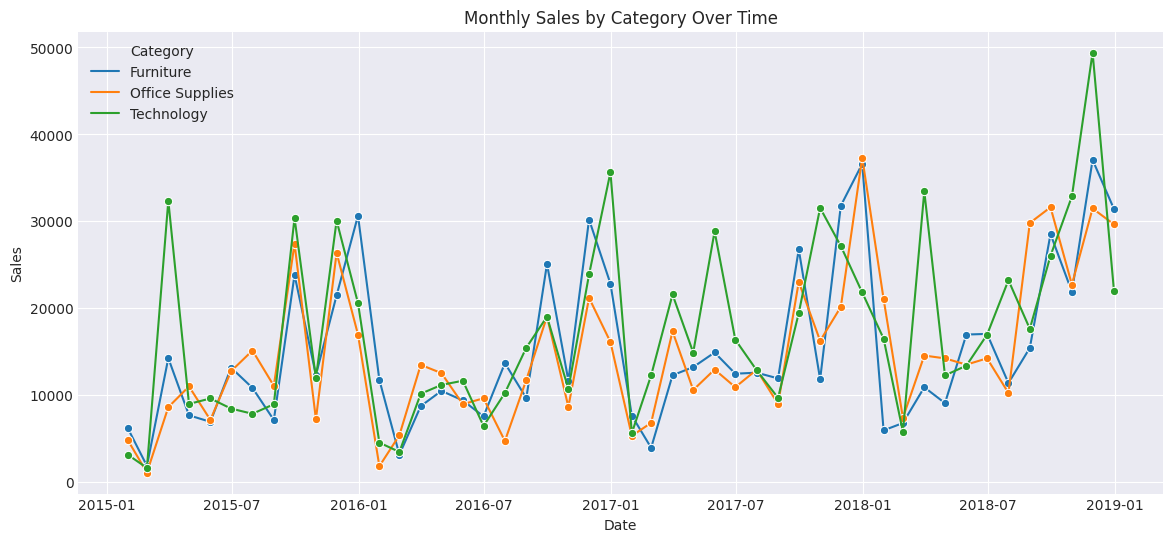

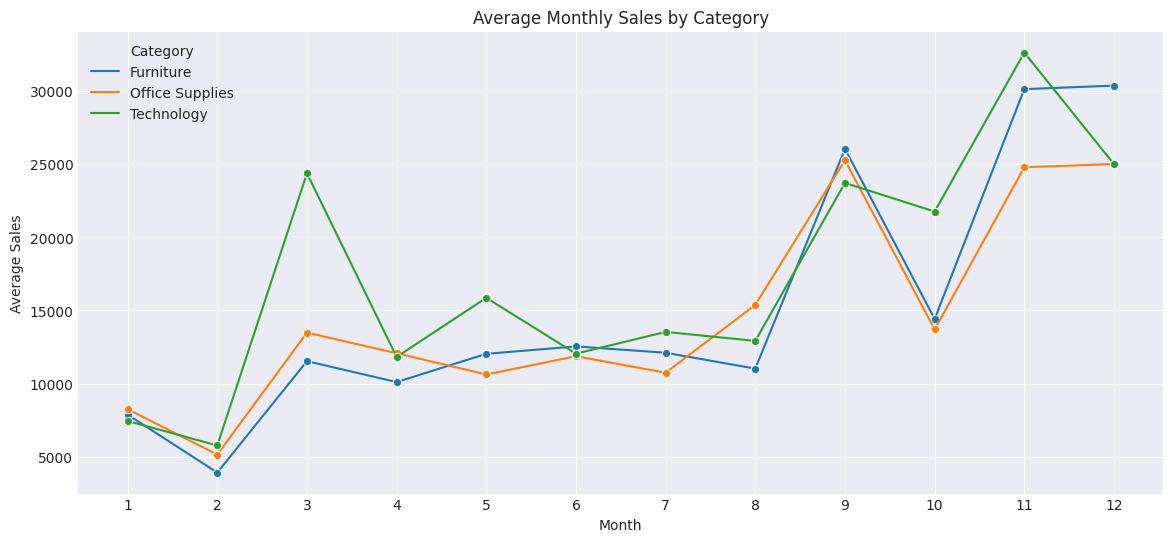

In [35]:
if 'Category' in df.columns:
    category_monthly = df.groupby(['Category']).resample('M')['Sales'].sum().reset_index()
    plt.figure(figsize=(14,6))
    sns.lineplot(data=category_monthly, x='Order Date', y='Sales', hue='Category', marker='o')
    plt.title("Monthly Sales by Category Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.show()

    category_monthly['Month'] = category_monthly['Order Date'].dt.month
    cat_avg = category_monthly.groupby(['Category', 'Month'])['Sales'].mean().reset_index()

    plt.figure(figsize=(14,6))
    sns.lineplot(x='Month', y='Sales', hue='Category', data=cat_avg, marker='o')
    plt.title("Average Monthly Sales by Category")
    plt.xlabel("Month")
    plt.ylabel("Average Sales")
    plt.xticks(range(1,13))
    plt.show()

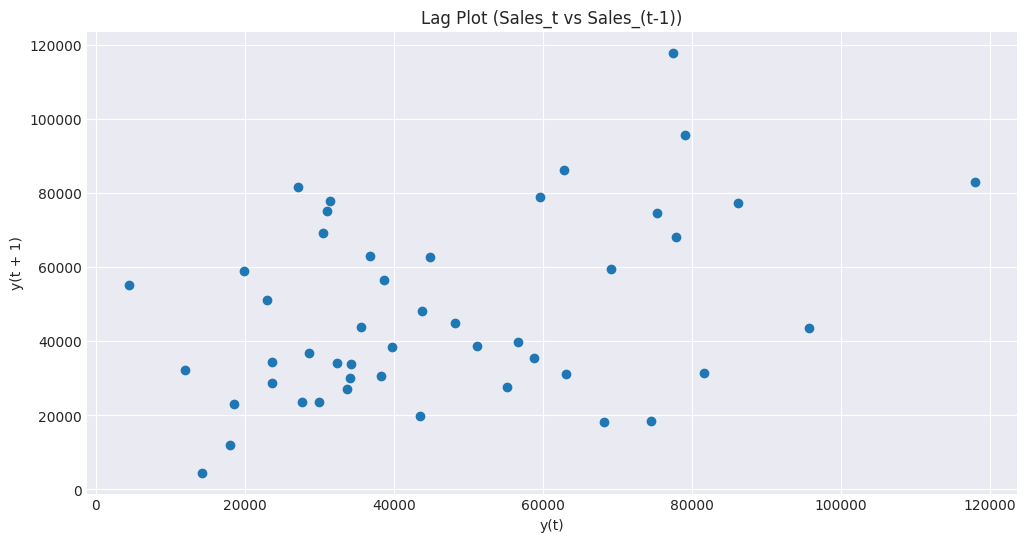

In [36]:
pd.plotting.lag_plot(monthly_sales)
plt.title("Lag Plot (Sales_t vs Sales_(t-1))")
plt.show()

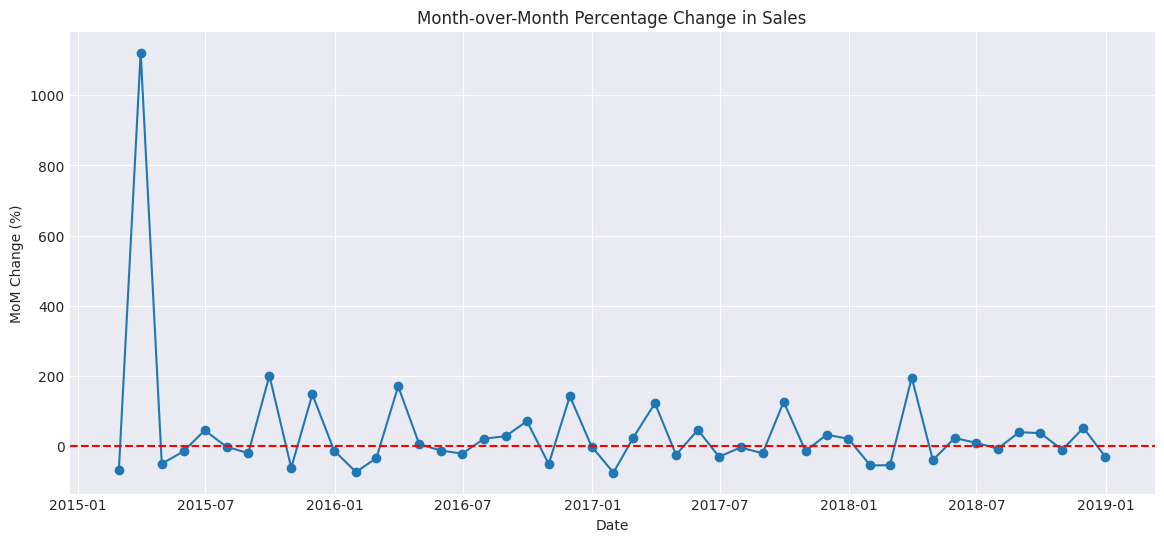

In [37]:
monthly_df['MoM_Change'] = monthly_df['Sales'].pct_change() * 100
plt.figure(figsize=(14,6))
plt.plot(monthly_df.index, monthly_df['MoM_Change'], marker='o', linewidth=1.5)
plt.title("Month-over-Month Percentage Change in Sales")
plt.xlabel("Date")
plt.ylabel("MoM Change (%)")
plt.axhline(0, color='red', linestyle='--')
plt.show()

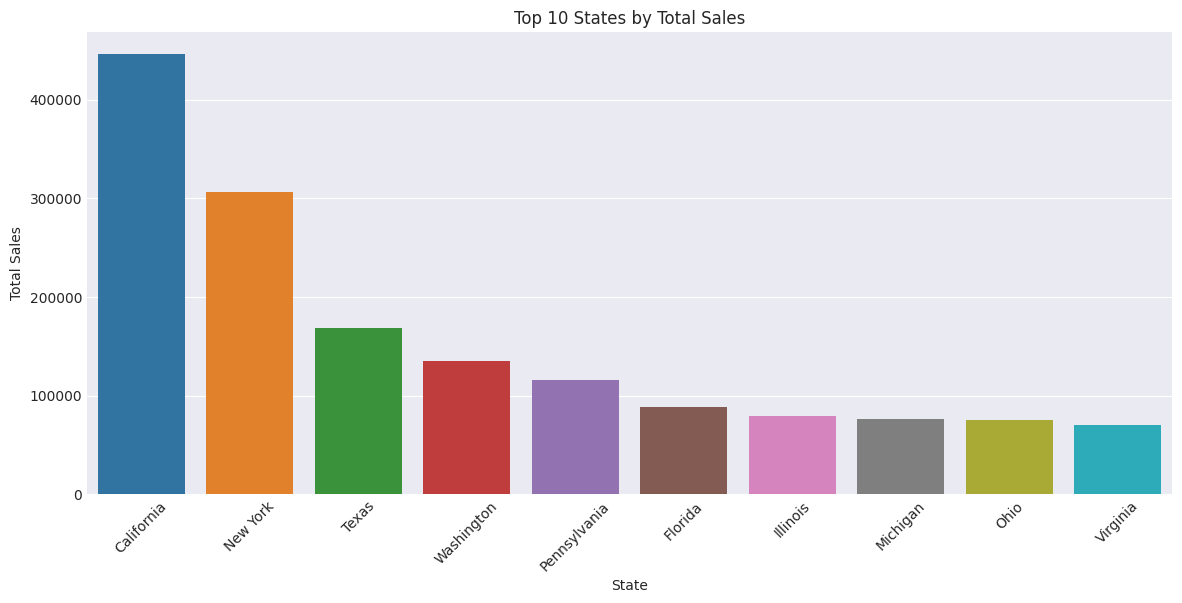

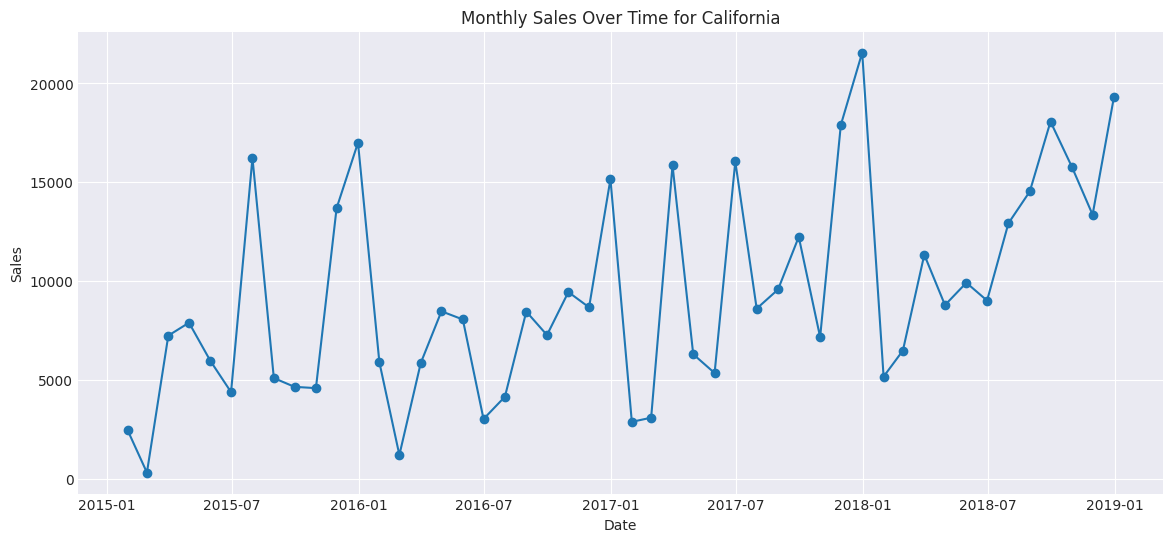

In [38]:
if 'State' in df.columns:
    state_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(14,6))
    sns.barplot(x=state_sales.index, y=state_sales.values)
    plt.title("Top 10 States by Total Sales")
    plt.xlabel("State")
    plt.ylabel("Total Sales")
    plt.xticks(rotation=45)
    plt.show()

    # If we want to explore seasonality in top states:
    top_state = state_sales.index[0]  # The state with highest total sales
    top_state_series = df[df['State'] == top_state].resample('M')['Sales'].sum()
    plt.figure(figsize=(14,6))
    plt.plot(top_state_series.index, top_state_series.values, marker='o')
    plt.title(f"Monthly Sales Over Time for {top_state}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.show()

# Model Building

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet 

In [40]:
def initial_data_report(df, head_count=5):
    print("Data Shape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nFirst Few Rows:\n", df.head(head_count))
    print("\nLast Few Rows:\n", df.tail(head_count))
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nDescriptive Statistics:\n", df.describe([0,0.05,0.5,0.95,0.99,1]).T)
    print("\nUnique Values Count:\n", df.nunique())

In [41]:
def remove_outliers_iqr(dataframe, col_name):
    Q1 = dataframe[col_name].quantile(0.25)
    Q3 = dataframe[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return dataframe[(dataframe[col_name] >= lower) & (dataframe[col_name] <= upper)]

In [42]:
def evaluate_forecast(actual, predicted, model_name="Model"):
    mse = mean_squared_error(actual, predicted)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    print(f"\n{model_name} Performance:")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    return mse, rmse, mae

In [43]:
def stationary_check(series):
    print("\nAugmented Dickey-Fuller Test:")
    adf_res = adfuller(series.dropna(), autolag='AIC')
    print("ADF Statistic:", adf_res[0])
    print("p-value:", adf_res[1])
    for k, v in adf_res[4].items():
        print(f"Critical Value {k}: {v}")
    print("ADF suggests stationary." if adf_res[1]<0.05 else "ADF suggests non-stationary.")

    print("\nKPSS Test:")
    kpss_res = kpss(series.dropna(), regression='c', nlags='auto')
    print("KPSS Statistic:", kpss_res[0])
    print("p-value:", kpss_res[1])
    for k, v in kpss_res[3].items():
        print(f"Critical Value {k}: {v}")
    print("KPSS suggests non-stationary." if kpss_res[1]<0.05 else "KPSS suggests stationary.")

In [44]:
def moving_average_predict(train_series, horizon=1, window=3):
    history = list(train_series)
    preds = []
    for _ in range(horizon):
        if len(history) < window:
            yhat = np.mean(history)
        else:
            yhat = np.mean(history[-window:])
        preds.append(yhat)
        history.append(yhat)
    return preds

In [45]:
def holtwinters_search(train, test, trends, seasonals, seasonal_periods_options):
    best_mse = np.inf
    best_params = None
    best_fit = None
    for tr in trends:
        for se in seasonals:
            for sp in seasonal_periods_options:
                try:
                    hw_model = ExponentialSmoothing(train, trend=tr, seasonal=se, seasonal_periods=sp)
                    hw_fit = hw_model.fit()
                    hw_forecast = hw_fit.forecast(len(test))
                    mse = mean_squared_error(test, hw_forecast)
                    if mse < best_mse:
                        best_mse = mse
                        best_params = (tr, se, sp)
                        best_fit = hw_fit
                except:
                    continue
    return best_fit, best_params, best_mse

In [46]:
def sarimax_search(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    best_mse = np.inf
    best_order = None
    best_seasonal = None
    best_result = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = SARIMAX(train, order=(p,d,q),
                                                seasonal_order=(P,D,Q,m),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                res = model.fit(disp=False)
                                fcast = res.forecast(len(test))
                                mse = mean_squared_error(test, fcast)
                                if mse < best_mse:
                                    best_mse = mse
                                    best_order = (p,d,q)
                                    best_seasonal = (P,D,Q,m)
                                    best_result = res
                            except:
                                continue
    return best_result, best_order, best_seasonal, best_mse

In [47]:
def run_prophet_model(monthly_series):
    data = monthly_series.reset_index()
    data.columns = ['ds','y']

    train_size = int(len(data)*0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]

    model = Prophet(yearly_seasonality=True,
                    weekly_seasonality=False,
                    daily_seasonality=False,
                    seasonality_mode='multiplicative',
                    changepoint_prior_scale=0.5,
                    seasonality_prior_scale=10)
    model.fit(train_data)

    future = model.make_future_dataframe(periods=len(test_data), freq='M')
    forecast = model.predict(future)
    forecast_test = forecast.iloc[-len(test_data):]

    evaluate_forecast(test_data['y'], forecast_test['yhat'], model_name="Prophet")

    model.plot(forecast)
    plt.title("Prophet Forecast")
    plt.show()

    model.plot_components(forecast)
    plt.show()

    return model, forecast

In [48]:
def main_pipeline(filepath):
    df = pd.read_csv(filepath)
    print("Initial Data Review:")
    initial_data_report(df)

    for drop_col in ["Row ID", "Country", "Postal Code"]:
        if drop_col in df.columns:
            df.drop(columns=drop_col, inplace=True, errors='ignore')

    df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', errors='coerce')
    df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y', errors='coerce')

    df.dropna(subset=['Order Date','Sales'], inplace=True)

    if df.duplicated().sum() > 0:
        df.drop_duplicates(inplace=True)

    print("\nPost-Cleaning Data Review:")
    initial_data_report(df, head_count=3)

    df = remove_outliers_iqr(df, "Sales")

    df.sort_values('Order Date', inplace=True)
    df.set_index('Order Date', inplace=True)

    monthly_sales = df['Sales'].resample('M').sum()
    print("\nMonthly Aggregated Sales Head:\n", monthly_sales.head())

    print("\nStationarity Tests on Monthly Sales:")
    stationary_check(monthly_sales)

    fig, axes = plt.subplots(1,2,figsize=(14,5))
    plot_acf(monthly_sales.dropna(), lags=24, ax=axes[0])
    axes[0].set_title("ACF")
    plot_pacf(monthly_sales.dropna(), lags=24, ax=axes[1], method='ywm')
    axes[1].set_title("PACF")
    plt.show()

    train_size = int(len(monthly_sales)*0.8)
    train, test = monthly_sales.iloc[:train_size], monthly_sales.iloc[train_size:]

    ma_preds = moving_average_predict(train, horizon=len(test), window=3)
    evaluate_forecast(test, ma_preds, "Moving Average Baseline")

    trend_opts = ['add', 'mul', None]
    seasonal_opts = ['add', 'mul', None]
    season_periods = [6, 12, 24]
    hw_model, hw_params, hw_mse = holtwinters_search(train, test, trend_opts, seasonal_opts, season_periods)
    hw_forecast = hw_model.forecast(len(test))
    evaluate_forecast(test, hw_forecast, model_name=f"Holt-Winters {hw_params}")

    p_vals = [0,1,2]
    d_vals = [0,1]
    q_vals = [0,1,2]
    P_vals = [0,1]
    D_vals = [0,1]
    Q_vals = [0,1]
    m = 12  
    sarima_res, sarima_order, sarima_seasonal, sarima_mse = sarimax_search(train, test,
                                                                          p_vals, d_vals, q_vals,
                                                                          P_vals, D_vals, Q_vals, m)
    sarima_pred = sarima_res.forecast(len(test))
    evaluate_forecast(test, sarima_pred, model_name=f"SARIMAX {sarima_order}{sarima_seasonal}")

    prophet_model, prophet_forecast = run_prophet_model(monthly_sales)

    print("\nModel evaluations completed. Review above metrics and plots for comparisons.")

    return {
        "monthly_sales": monthly_sales,
        "train": train,
        "test": test,
        "holtwinters_model": hw_model,
        "sarima_model": sarima_res,
        "prophet_model": prophet_model
    }

Initial Data Review:
Data Shape: (9800, 18)

Data Types:
 Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code      float64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
dtype: object

First Few Rows:
    Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Stan

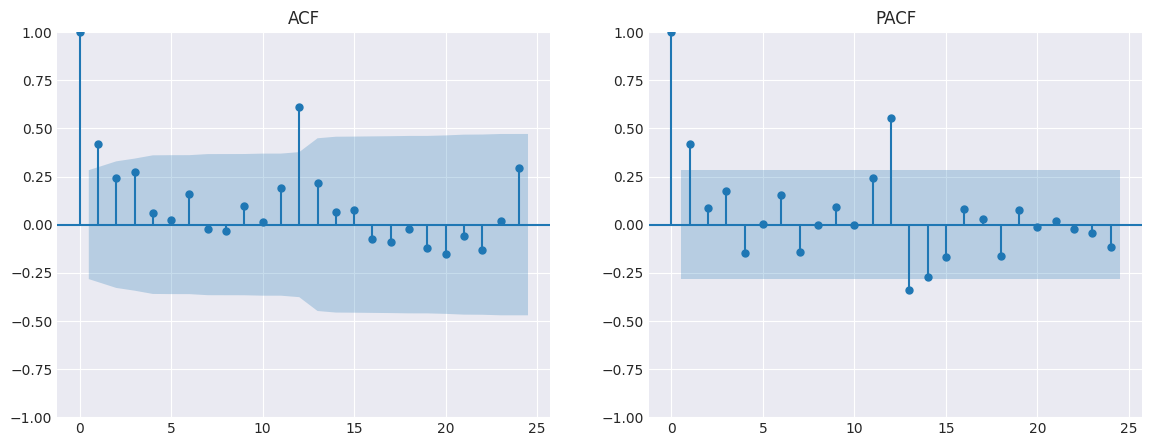


Moving Average Baseline Performance:
MSE: 175779397.32655996
RMSE: 13258.182278372853
MAE: 10514.518364753341

Holt-Winters ('add', 'mul', 12) Performance:
MSE: 9504269.162762282
RMSE: 3082.8994733468494
MAE: 2704.6997427135625

SARIMAX (1, 0, 1)(1, 0, 1, 12) Performance:
MSE: 3935385.9659210965
RMSE: 1983.7807252620175
MAE: 1567.7173126044238


02:29:40 - cmdstanpy - INFO - Chain [1] start processing
02:29:40 - cmdstanpy - INFO - Chain [1] done processing



Prophet Performance:
MSE: 10367218.490486491
RMSE: 3219.816530562959
MAE: 2641.363338619104


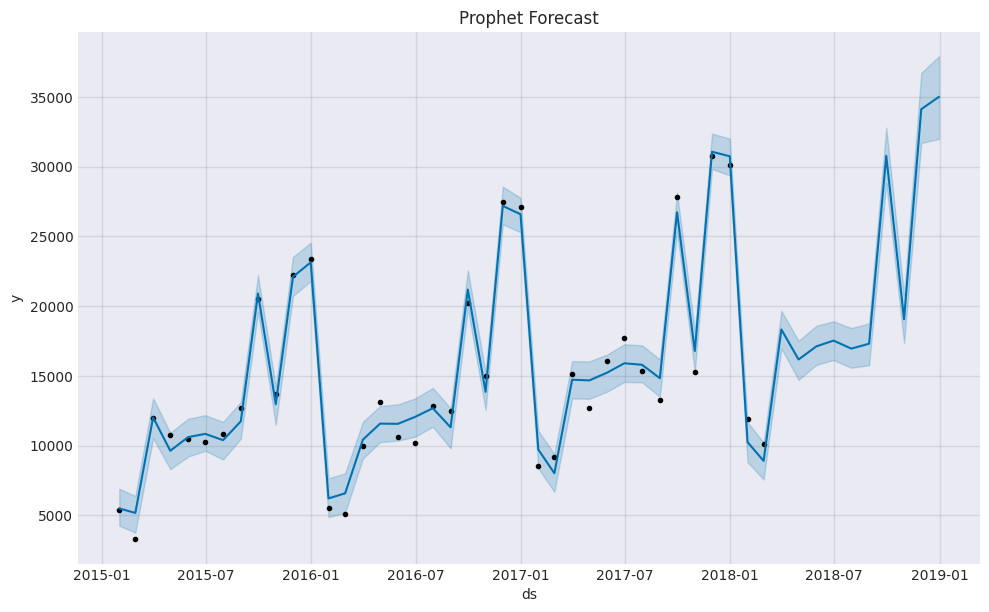

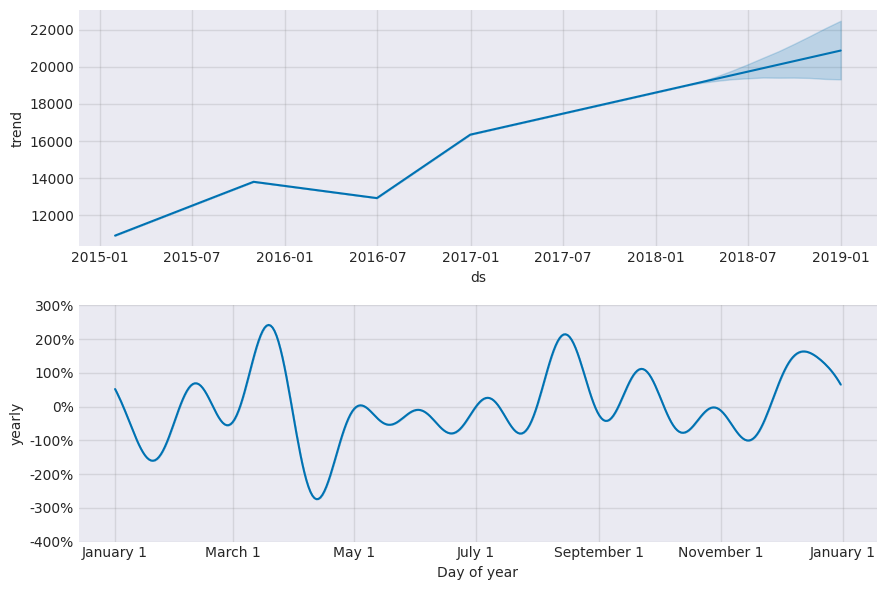


Model evaluations completed. Review above metrics and plots for comparisons.


In [49]:
result = main_pipeline("/kaggle/input/sales-forecasting/train.csv")